<a href="https://colab.research.google.com/github/quanvu0996/compet/blob/master/kalapa_4student_traditional_ML_ordinal_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, DenseFeatures, Dropout, BatchNormalization, Embedding
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import AUC, Precision, Recall
import tensorflow.keras.backend as K
from tensorflow import feature_column as fc
from keras.wrappers.scikit_learn import KerasRegressor

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc
from sklearn.utils import check_random_state
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin

import xgboost as xgb
from lightgbm import LGBMClassifier

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
print(pd.__version__)
print(tf.__version__)

1.0.5
2.3.0


In [3]:
submision_path = '/content/drive/My Drive/Data/colabs_data/kalapa_4students/simple_submission.csv'
train_path = '/content/drive/My Drive/Data/colabs_data/kalapa_4students/train.csv'
test_path = '/content/drive/My Drive/Data/colabs_data/kalapa_4students/test.csv'

added_data_path= '/content/drive/My Drive/Data/colabs_data/kalapa_4students/exdata.txt'

In [4]:
def load_data(train_path, test_path, label_col = 'label'):
    train_data = pd.read_csv(train_path)
    predict_data = pd.read_csv(test_path)
    return train_data, predict_data

train_data, predict_data = load_data( train_path, test_path )
train_data = train_data[train_data['label'].isin( [0,1] )].replace('notfound','missing')
predict_data = predict_data.replace('notfound','missing')
cols = train_data.columns

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (35,43) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (34,42) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [5]:
# train_data.merge()
added_data = pd.read_csv(added_data_path, sep='\t', encoding='utf-8', names = ['homeTownState', 'area', 'population', 'pop_density'])
added_data

,homeTownState,area,population,pop_density
0,province,area,population,pop_density
1,Hà Nội,3358.6,8093.9,2410
2,Vĩnh Phúc,1235.9,1154.8,934
3,Bắc Ninh,822.7,1378.6,1676
4,Quảng Ninh,6178.2,1324.8,214
...,...,...,...,...
60,Cần Thơ,1439,1236,859
61,Hậu Giang,1621.7,732.2,451
62,Sóc Trăng,3311.9,1199.5,362
63,Bạc Liêu,2669,908.2,340


In [8]:
# unique_check = train_data['homeTownState'].unique()
# val_check = train_data.groupby(['homeTownState'])['id'].count().sort_values(ascending=False)
# val_check['Thanh Hóa Province']

Clean data

In [9]:
vals_homeTownState = { 'Hanoi' : 'Hà Nội' , 
'Ho Chi Minh City' : 'TP.Hồ Chí Minh' , 
'Thanh Hóa Province' : 'Thanh Hoá' , 
'Nghệ An Province' : 'Nghệ An' , 
'Đồng Nai Province' : 'Đồng Nai' , 
'Haiphong' : 'Hải Phòng' , 
'Khánh Hòa Province' : 'Khánh Hoà' , 
'Thái Bình Province' : 'Thái Bình' , 
'Bắc Giang Province' : 'Bắc Giang' , 
'Hà Tĩnh Province' : 'Hà Tĩnh' , 
'Bình Định Province' : 'Bình Định' , 
'Nam Định Province' : 'Nam Định' , 
'Bắc Ninh Province' : 'Bắc Ninh' , 
'Quảng Ngãi Province' : 'Quảng Ngãi' , 
'Hải Dương Province' : 'Hải Dương' , 
'Quảng Nam Province' : 'Quảng Nam' , 
'Thái Nguyên Province' : 'Thái Nguyên' , 
'An Giang Province' : 'An Giang' , 
'Cần Thơ' : 'Cần Thơ' , 
'Đắk Lắk Province' : 'Đắk Lắk' , 
'Da Nang' : 'Đà Nẵng' , 
'Tiền Giang Province' : 'Tiền Giang' , 
'Phú Thọ Province' : 'Phú Thọ' , 
'Quảng Ninh Province' : 'Quảng Ninh' , 
'Ninh Bình Province' : 'Ninh Bình' , 
'Thừa Thiên–Huế Province' : 'Thừa Thiên Huế' , 
'Bến Tre Province' : 'Bến Tre' , 
'Hưng Yên Province' : 'Hưng Yên' , 
'Bà Rịa–Vũng Tàu Province' : 'Bà Rịa - Vũng Tàu' , 
'Kiên Giang Province' : 'Kiên Giang' , 
'Quảng Trị Province' : 'Quảng Trị' , 
'Đồng Tháp Province' : 'Đồng Tháp' , 
'Tây Ninh Province' : 'Tây Ninh' , 
'Sóc Trăng Province' : 'Sóc Trăng' , 
'Lâm Đồng Province' : 'Lâm Đồng' , 
'Lạng Sơn Province' : 'Lạng Sơn' , 
'Bình Thuận Province' : 'Bình Thuận' , 
'Gia Lai Province' : 'Gia Lai' , 
'Sơn La Province' : 'Sơn La' , 
'Cà Mau Province' : 'Cà Mau' , 
'Tuyên Quang Province' : 'Tuyên Quang' , 
'Quảng Bình Province' : 'Quảng Bình' , 
'Vĩnh Long Province' : 'Vĩnh Long' , 
'Long An Province' : 'Long An' , 
'Yên Bái Province' : 'Yên Bái' , 
'Bạc Liêu Province' : 'Bạc Liêu' , 
'Hòa Bình Province' : 'Hoà Bình' , 
'Trà Vinh Province' : 'Trà Vinh' , 
'Bình Dương Province' : 'Bình Dương' , 
'Phú Yên Province' : 'Phú Yên' , 
'Hà Nam Province' : 'Hà Nam' , 
'Vĩnh Phúc Province' : 'Vĩnh Phúc' , 
'Lào Cai Province' : 'Lào Cai' , 
'Điện Biên Province' : 'Điện Biên' , 
'Ninh Thuận Province' : 'Ninh Thuận' , 
'Cao Bằng Province' : 'Cao Bằng' , 
'Hà Giang Province' : 'Hà Giang' , 
'Bắc Kạn Province' : 'Bắc Kạn' , 
'Kon Tum Province' : 'Kon Tum' , 
'Hậu Giang Province' : 'Hậu Giang' , 
'Sarawak' : 'Sarawak' , 
'Đắk Nông Province' : 'Đắk Nông' , 
'Seoul' : 'Seoul' , 
'Bình Phước Province' : 'Bình Phước' , 
'New York' : 'New York' , 
'England' : 'England' , 
'Lai Châu Province' : 'Lai Châu' , 
'California' : 'California' , 
'Hong Kong' : 'Hong Kong' , 
'Orientale' : 'Orientale' , 
'Dubai' : 'Dubai' , 
'Guangdong' : 'Guangdong' , 
'Île-de-France' : 'Île-de-France' }

In [10]:
train_data['homeTownState'] = train_data['homeTownState'].fillna('other').map(vals_homeTownState ).fillna('Foreign')

In [11]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(train_data.groupby(['homeTownState'])['label'].count().sort_values())

In [12]:
train_data = train_data.merge(added_data, how = 'left', on = 'homeTownState')
predict_data = predict_data.merge(added_data, how = 'left', on = 'homeTownState')

In [31]:
train_data[[ 'area', 'population', 'pop_density']] = train_data[[ 'area', 'population', 'pop_density']].astype('float64')
predict_data[[ 'area', 'population', 'pop_density']] = predict_data[[ 'area', 'population', 'pop_density']].astype('float64')

In [49]:
len(train_data.columns)

198

In [32]:
# Nhãn
cols_label = ['label']
# Đặc trưng binary
cols_fts_binary = [i for i in train_data.select_dtypes(include=['float64','int64']).columns 
                   if len(set(train_data[i].fillna(0)) - {0,1} ) == 0 and i not in cols_label]
# định dang datte yyyy-mm-dd
cols_date = ['Field_1','Field_2','Field_5','Field_6','Field_7','Field_8','Field_9','Field_11'
             ,'Field_15','Field_25','Field_32','Field_33','Field_35','Field_40','Field_43','Field_44'
             ,'F_startDate','F_endDate','E_startDate','E_endDate','C_startDate','C_endDate','G_startDate','G_endDate'
             ,'A_startDate','A_endDate']
# định dạng date yyymmdd
cols_date2 = ['ngaySinh', 'Field_34']
# Đặc trưng dạng văn bản
cols_docs = ['Field_46','diaChi','Field_48','Field_49','currentLocationName','homeTownName','Field_56']
# Định danh bản ghi
cols_id = ['id','Field_45'] +[i for i in train_data.select_dtypes(include = ['object']).columns 
                              if len(train_data[i].unique()) >=350 and i not in cols_date + cols_date2+cols_docs]
# Đặc trưng dạng categorical
cols_categorical = [i for i in train_data.select_dtypes(include = ['object']).columns
                    if i not in cols_id + cols_label+cols_date2+cols_date+cols_docs]
# Đặc trưng số
cols_fts_num = [ i for i in predict_data.select_dtypes(include=['float64','int64']).columns 
                if i not in cols_id + cols_label + cols_fts_binary + cols_date2+cols_date+cols_docs]

In [33]:
# Đặc trưng số có dạng như categorical
cols_num_like_cat = [i for i in cols_fts_num if len(train_data[i].unique()) <= 15 ]
# Đặc trưng số đã kiểm chứng
cols_num = [i for i in cols_fts_num if i not in cols_num_like_cat]

# cols_categorical = list(set(cols_categorical + cols_num_like_cat)) # Không cần thiết, convert qua lại ordinalencoder
cols_fts_num = [i for i in cols_fts_num if i not in cols_num_like_cat ]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(train_data
                                                   ,train_data['label'].values
                                                   ,stratify = train_data['label'].values 
                                                   ,test_size = 0.2
                                                   )

In [16]:
X_train.shape

(42424, 198)

In [17]:
# OneHotEncoder(handle_unknown='ignore').fit(X_train[cols_categorical].astype(str).fillna('ms'))
# X_train[cols_categorical].astype(str).info()


In [18]:
# X_train[cols_date].head().apply(lambda x: ( pd.to_datetime(x.apply(lambda i: str(i)[0:10]) , format='%Y-%m-%d' , errors= 'coerce')  
#                                           - pd.to_datetime('20170101', format='%Y%m%d')).apply(lambda x: x.days)
#                               , axis = 1)
# X_train[cols_date].head().apply(lambda x: ( pd.to_datetime(x.apply(lambda i: str(i)[0:10]) , format=format , errors= 'coerce')  
#                               - pd.to_datetime('20170101', format='%Y%m%d')).apply(lambda x: x.days)
#                        , axis = 1)

# (pd.to_datetime( df[col].apply(lambda x: str(x)[0:10]), format='%Y-%m-%d' , errors= 'coerce') 
#                         - pd.to_datetime('20170101', format='%Y%m%d') ).apply(lambda x: x.days)

In [35]:
# lấy list value cho ordinalencoder
categories_val = []
for i in cols_categorical:
  categories_val.append(list( 
      pd.concat([train_data[i], predict_data[i]]).fillna('missing').apply(lambda x: str(x)).drop_duplicates( 
  ).sort_values().values) )

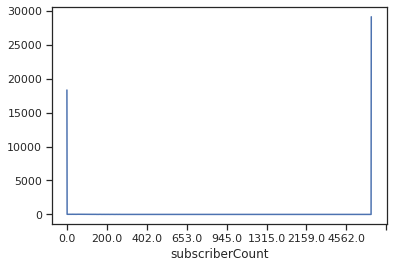

In [46]:
train_data.fillna('other').groupby(['subscriberCount'])['id'].count().plot()

In [21]:
for i in cols_fts_binary:
  print(train_data.fillna(-1).groupby([i])['label'].agg(['mean', 'count']))

              mean  count
Field_13                 
-1.0      0.348285  27466
 1.0      0.282820  25564
              mean  count
Field_14                 
-1.0      0.348285  27466
 1.0      0.282820  25564
              mean  count
Field_16                 
-1.0      0.348285  27466
 1.0      0.282820  25564
              mean  count
Field_17                 
-1.0      0.348285  27466
 1.0      0.282820  25564
              mean  count
Field_24                 
-1.0      0.348285  27466
 1.0      0.282820  25564
              mean  count
Field_26                 
-1.0      0.348285  27466
 1.0      0.282820  25564
              mean  count
Field_30                 
-1.0      0.348285  27466
 1.0      0.282820  25564
              mean  count
Field_31                 
-1.0      0.348285  27466
 1.0      0.282820  25564
              mean  count
Field_37                 
-1.0      0.348285  27466
 1.0      0.282820  25564
              mean  count
Field_39                 
-1.0      0.

In [48]:
len(selected_columns)

183

Test AUC
AUC:  0.7323166810809971
Gini:  0.46463336216199425


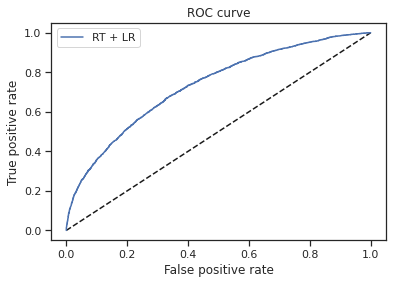

Train AUC
AUC:  0.7456893055294547
Gini:  0.49137861105890934


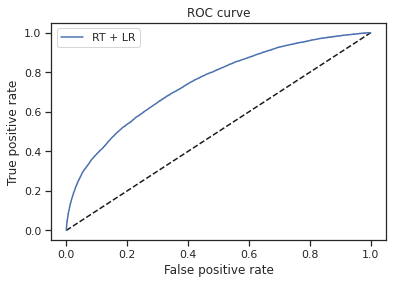

In [97]:
# Xây dựng pipeline và fit với tree-based
selected_columns = cols_categorical+cols_fts_num + cols_date + cols_date2 + cols_fts_binary + cols_num_like_cat

class ToString(BaseEstimator, TransformerMixin):
  '''Def 1 trans để convert các cột dạng số như categorical thành dạng cat => dùng được onehot'''
  def fit(self, X, y = None):
    return self
  def transform(self, X, y = None):
    X_ = X.copy() # creating a copy to avoid changes to original dataset
    X_ = X_.astype(str)
    return X_

# Xử lý datetime thành year, month, date như là dạng số - chỉ phù hợp cho tree-based
class DateToNum(BaseEstimator, TransformerMixin):
  def __init__(self, format = '%Y-%m-%d' ):
    self.format = format
  def fit(self, X, y = None):
    return self
  def transform(self, X, y = None):
    X_ = X.copy() # creating a copy to avoid changes to original dataset
    cols = X_.columns
    for i in X.columns:
      X_[i+'year_as_number'] = pd.to_datetime(X_[i].apply(lambda i: str(i)[0:10])
                                        , format= self.format , errors= 'coerce').dt.year -2010
      X_[i+'month_as_number'] = pd.to_datetime(X_[i].apply(lambda i: str(i)[0:10])
                                        , format= self.format , errors= 'coerce').dt.month
      X_[i+'day_as_number'] = pd.to_datetime(X_[i].apply(lambda i: str(i)[0:10])
                                        , format= self.format , errors= 'coerce').dt.day
    X_[cols] = X_[cols].apply(lambda x: ( pd.to_datetime(x.apply(lambda i: str(i)[0:10]) , format= self.format , errors= 'coerce')  
                              - pd.to_datetime('20170101', format='%Y%m%d')).apply(lambda x: x.days)
                       , axis = 1)
    return X_

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))
    , ('to_string', ToString())
    , ('onehot', OrdinalEncoder(categories=categories_val))
])

ordinal_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value= -1 ))
])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
    # , ('standard', StandardScaler()) # Với tree thì không cần standard
])

binary_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value= -1 ))
    # , ('standard', StandardScaler()) # Với tree thì không cần standard
])

datetime_pipe1 = Pipeline([
    ('datetime1', DateToNum(format='%Y-%m-%d'))
    # , ('standard', StandardScaler()) # Với tree thì không cần standard
    , ('imputer', SimpleImputer(strategy='mean'))
])

datetime_pipe2 = Pipeline([
    ('datetime2', DateToNum(format='%Y%m%d'))
    # , ('standard', StandardScaler()) # Với tree thì không cần standard
    , ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [
     ('cat', categorical_pipe, cols_categorical),
     ('ordinal', ordinal_pipe, cols_num_like_cat),
     ('num', numerical_pipe, cols_fts_num), 
     ('binary', binary_pipe, cols_fts_binary), 
     ('date1', datetime_pipe1, cols_date),
     ('date2', datetime_pipe2, cols_date2)
     ])

#xgb.XGBRegressor(objective="reg:linear", random_state=42, n_estimators =64, max_depth =7)
# LGBMClassifier(
#             nthread=4,
#             n_estimators=10000,
#             learning_rate=0.02,
#             num_leaves=128,
#             colsample_bytree=0.9497036,
#             subsample=0.8715623,
#             max_depth=8,
#             reg_alpha=0.041545473,
#             reg_lambda=0.0735294,
#             min_split_gain=0.0222415,
#             min_child_weight=39.3259775,
#             silent=-1,
#             verbose=-1
#         )
model = GradientBoostingClassifier(random_state=42, min_samples_leaf =100  ) # max_depth = 7 , loss = 'exponential' )

rf = Pipeline([
    ('preprocess', preprocessing),
    # ('pca', PCA(n_components = 512)),
    ('classifier', model)
])

rf.fit(X_train[selected_columns], y_train)
# cv = StratifiedKFold()

print('Test AUC')
try:
  y_pred_rt = rf.predict_proba(X_test[selected_columns])[:, 1]
except:
  y_pred_rt = rf.predict(X_test[selected_columns])

fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)
auc_s = auc(fpr_rt_lm, tpr_rt_lm)
print('AUC: ', auc_s)
print('Gini: ', 2*auc_s - 1)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print('Train AUC')
try:
  y_pred_rt = rf.predict_proba(X_train[selected_columns])[:, 1]
except:
  y_pred_rt = rf.predict(X_train[selected_columns])

fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_train, y_pred_rt)
auc_s = auc(fpr_rt_lm, tpr_rt_lm)
print('AUC: ', auc_s)
print('Gini: ', 2*auc_s - 1)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# score = cross_val_score(rf, X_train[selected_columns], y_train, cv=cv)

In [52]:
transform_pipeline = Pipeline([
    ('preprocess', preprocessing) ])#,
    # ('pca', PCA(n_components = 512)),

out_trans = transform_pipeline.fit_transform( X_train )

In [96]:
date_tesst = DateToNum()
X_datetest = date_tesst.fit_transform( X_train[['Field_1']].head(100) )
X_datetest

,Field_1,Field_1year_as_number,Field_1month_as_number,Field_1day_as_number
50175,465.0,8.0,4.0,11.0
4299,NaN,NaN,NaN,NaN
9614,359.0,7.0,12.0,26.0
18381,1024.0,9.0,10.0,22.0
41348,724.0,8.0,12.0,26.0
...,...,...,...,...
20131,1087.0,9.0,12.0,24.0
22973,NaN,NaN,NaN,NaN
39195,NaN,NaN,NaN,NaN
14451,NaN,NaN,NaN,NaN


In [94]:
X_

,Field_1,Field_2,Field_1year_as_number,Field_1month_as_number,Field_1day_as_number,Field_2year_as_number,Field_2month_as_number,Field_2day_as_number
50175,465.0,465.0,8.0,4.0,11.0,8.0,4.0,11.0
4299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9614,359.0,359.0,7.0,12.0,26.0,7.0,12.0,26.0
18381,1024.0,1033.0,9.0,10.0,22.0,9.0,10.0,31.0
41348,724.0,726.0,8.0,12.0,26.0,8.0,12.0,28.0
...,...,...,...,...,...,...,...,...
20131,1087.0,1088.0,9.0,12.0,24.0,9.0,12.0,25.0
22973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
X_train[['Field_1']]

,Field_1
50175,2018-04-11T02:38:49.565Z
4299,NaN
9614,2017-12-26T04:47:51.746Z
18381,2019-10-22T01:38:10.267Z
41348,2018-12-26T04:17:06.921Z
...,...
21795,2019-12-17T05:08:14Z
27868,NaN
29756,2017-03-17T14:29:21.807Z
14720,NaN


In [67]:
pd.to_datetime(X_train['Field_1'].apply(lambda i: str(i)[0:10])
                                        , format= '%Y-%m-%d' , errors= 'coerce').dt.year -2010

50175    8.0
4299     NaN
9614     7.0
18381    9.0
41348    8.0
        ... 
21795    9.0
27868    NaN
29756    7.0
14720    NaN
183      9.0
Name: Field_1, Length: 42424, dtype: float64

In [69]:
X_datetest[X_datetest['Field_1year_as_number'].notnull()]

,Field_1,Field_1year_as_number,Field_1month_as_number,Field_1day_as_number


In [50]:
rf['pca'].explained_variance_ratio_

AttributeError: ignored

In [ ]:
# X_train[cols_date].apply(lambda x: ( pd.to_datetime(x.apply(lambda i: str(i)[0:10]) , format=format , errors= 'coerce')  
#                               - pd.to_datetime('20170101', format='%Y%m%d')).apply(lambda x: x.days)
#                        , axis = 1)

In [ ]:
# # SVM
# categorical_pipe = Pipeline([
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])
# numerical_pipe = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean'))
#     , ('standard', StandardScaler()) # Với tree thì không cần standard
# ])

# preprocessing = ColumnTransformer(
#     [('cat', categorical_pipe, cols_categorical),
#      ('num', numerical_pipe, cols_fts_num)])

# pipeline = Pipeline([
#     ('preprocess', preprocessing),
#     ('classifier', SVC(probability = True))
# ])
# pipeline.fit(X_train, y_train)

# y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
# fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)
# print('AUC: ', auc(fpr_rt_lm, tpr_rt_lm))

# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

In [ ]:
# # TF nets
# class DenseTransformer(TransformerMixin):

#     def fit(self, X, y=None, **fit_params):
#         return self

#     def transform(self, X, y=None, **fit_params):
#         return X.todense()

# categorical_pipe = Pipeline([
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('to_string', ToString()),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])
# numerical_pipe = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean'))
#     # , ('standard', StandardScaler()) # Với tree thì không cần standard
# ])

# preprocessing = ColumnTransformer(
#     [('cat', categorical_pipe, cols_categorical),
#      ('num', numerical_pipe, cols_fts_num)])

# def building_net_func():
#   net = Sequential(
#       [
#       BatchNormalization (),
#       Dense(1024, activation ='relu', kernel_initializer = 'he_normal'),
#       Dropout(0.5), 
#       BatchNormalization (),
#       Dense(128, activation ='relu', kernel_initializer = 'he_normal'),
#       Dropout(0.25), 
#       # BatchNormalization (),
#       # Dense(64, activation ='relu', kernel_initializer = 'he_normal'),
#       # Dropout(0.25), 
#       # BatchNormalization (),
#       Dense(16, activation ='relu', kernel_initializer = 'he_normal'),
#       BatchNormalization (),
#       Dense(1, activation ='sigmoid', kernel_initializer = 'he_normal')])
#   net.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = [ AUC() ] )
#   return net

# net = KerasRegressor(build_fn= building_net_func, verbose = 1)

# pipeline = Pipeline([
#     ('preprocess', preprocessing),
#     ('todense', DenseTransformer()),
#     ('classifier', net)
# ])
# pipeline.fit(
#     pd.concat([X_train, X_test])[selected_columns],
#     np.concatenate( [y_train, y_test])
#     , classifier__epochs = 8
#     , classifier__batch_size = 1024
#     , classifier__validation_split = 0.2)

# y_pred_rt = pipeline.predict(X_test)
# fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)
# print('AUC: ', auc(fpr_rt_lm, tpr_rt_lm))

# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

In [ ]:
prediction = pipeline.predict(predict_data[selected_columns])
res_df = pd.DataFrame({'id': predict_data.id, 'label': prediction})
res_df.to_csv('submission_net.csv', index=False)

In [ ]:
# ohe = (rf.named_steps['preprocess']
#          .named_transformers_['cat']
#          .named_steps['onehot'])
# feature_names = ohe.get_feature_names(input_features=cols_categorical)
# feature_names = np.r_[feature_names, cols_fts_num]

# tree_feature_importances = (
#     rf.named_steps['classifier'].feature_importances_)
# sorted_idx = tree_feature_importances.argsort()

# fts_im_num = 15
# y_ticks = np.arange(0, fts_im_num)
# fig, ax = plt.subplots()
# ax.barh(y_ticks, tree_feature_importances[sorted_idx[:fts_im_num]])
# ax.set_yticklabels(feature_names[sorted_idx[:fts_im_num]])
# ax.set_yticks(y_ticks)
# ax.set_title("Random Forest Feature Importances (MDI)")
# fig.tight_layout()
# plt.show()

In [ ]:
sorted_idx[:15]

Dự đoán kết quả

In [ ]:
try:
  prediction = rf.predict_proba(predict_data[selected_columns])[:, 1]
except:
  prediction = rf.predict(predict_data[selected_columns])
res_df = pd.DataFrame({'id': predict_data.id, 'label': prediction})
res_df.to_csv('submission.csv', index=False)

In [ ]:
predict_